FIRST STEPS

In [1]:
from utils import *

In [2]:

# Cargamos imagenes
train_images_b, train_labels_b = load_dataset_split_sobel('data/original/balanced/train')
val_images_b, val_labels_b = load_dataset_split_sobel('data/original/balanced/val')
test_images_b, test_labels_b = load_dataset_split_sobel('data/original/balanced/test')

train_images_f, train_labels_f = load_dataset_split_sobel('data/augmented/FracAtlas/train')
val_images_f, val_labels_f = load_dataset_split_sobel('data/augmented/FracAtlas/val')
test_images_f, test_labels_f = load_dataset_split_sobel('data/augmented/FracAtlas/test')

train_images = np.concatenate([train_images_b, train_images_f])
train_labels = np.concatenate([train_labels_b, train_labels_f])
test_images = np.concatenate([test_images_b, test_images_f])
test_labels = np.concatenate([test_labels_b, test_labels_f])
val_images = np.concatenate([val_images_b, val_images_f])
val_labels = np.concatenate([val_labels_b, val_labels_f])





In [3]:
# Creamos Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [4]:
#Calculamos pesos en función del conteo
class_weights = compute_class_weight('balanced', 
                                   classes=np.unique(train_labels), 
                                   y=train_labels)
class_weight = {0: class_weights[0], 1: class_weights[1]}


In [5]:
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(256, (3, 3), activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

In [6]:

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    class_weight=class_weight,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/50


320/320 [==============================] - 52s 121ms/step - loss: 0.3650 - accuracy: 0.8840 - precision: 0.9110 - recall: 0.8699 - auc: 0.9426 - val_loss: 2.3156 - val_accuracy: 0.4889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6132 - lr: 0.0010
Epoch 2/50
320/320 [==============================] - 47s 147ms/step - loss: 0.4160 - accuracy: 0.8290 - precision: 0.8917 - recall: 0.7774 - auc: 0.9106 - val_loss: 2.3849 - val_accuracy: 0.5077 - val_precision: 0.9583 - val_recall: 0.0385 - val_auc: 0.6994 - lr: 0.0010
Epoch 3/50
320/320 [==============================] - 44s 137ms/step - loss: 0.3641 - accuracy: 0.8552 - precision: 0.8858 - recall: 0.8400 - auc: 0.9276 - val_loss: 2.8341 - val_accuracy: 0.4923 - val_precision: 1.0000 - val_recall: 0.0067 - val_auc: 0.6562 - lr: 0.0010
Epoch 4/50
320/320 [==============================] - 46s 145ms/step - loss: 0.3237 - accuracy: 0.8774 - precision: 0.9082 - recall: 0.8598 - auc: 0.9410 - val_loss: 0.7416 

In [7]:
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")

37/37 [==============================] - 4s 97ms/step - loss: 0.3217 - accuracy: 0.8921 - precision: 0.9118 - recall: 0.8857 - auc: 0.9496
Test Accuracy: 0.892123281955719
Test Precision: 0.9117646813392639
Test Recall: 0.8857142925262451
Test AUC: 0.9495927691459656


37/37 [==============================] - 5s 90ms/step


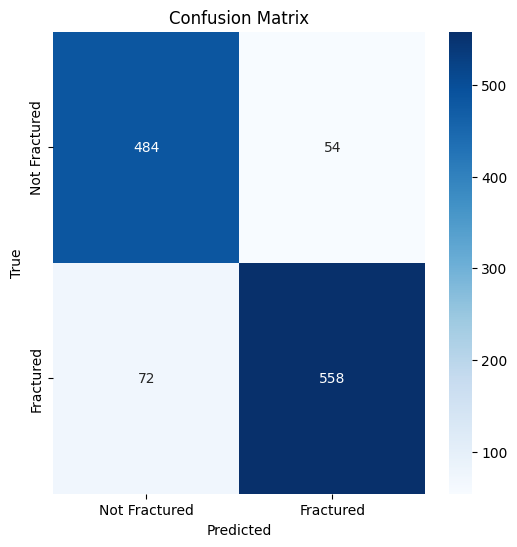

In [8]:
plot_conf_matrix(model, test_images, test_labels)

In [9]:
filename = 'binary_model_v4_1_augmented_sobel.pkl'
create_pkl(filename, model)

In [10]:
model.save('binary_model_v4_augmented.h5') 

c:\Users\Nacho MPra\.conda\envs\fracture_detection\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


37/37 [==============================] - 3s 80ms/step


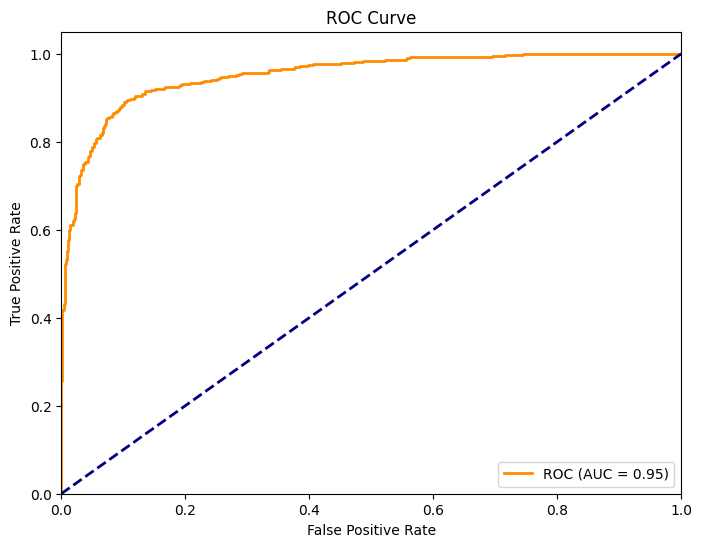

In [11]:
plot_roc_curve(model, test_images, test_labels)

37/37 [==============================] - 2s 60ms/step


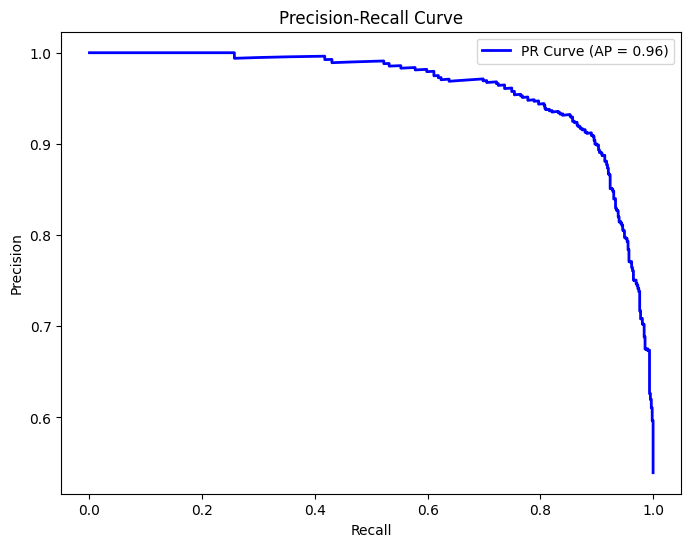

In [12]:
plot_pr_curve(model, test_images, test_labels)

37/37 [==============================] - 3s 67ms/step


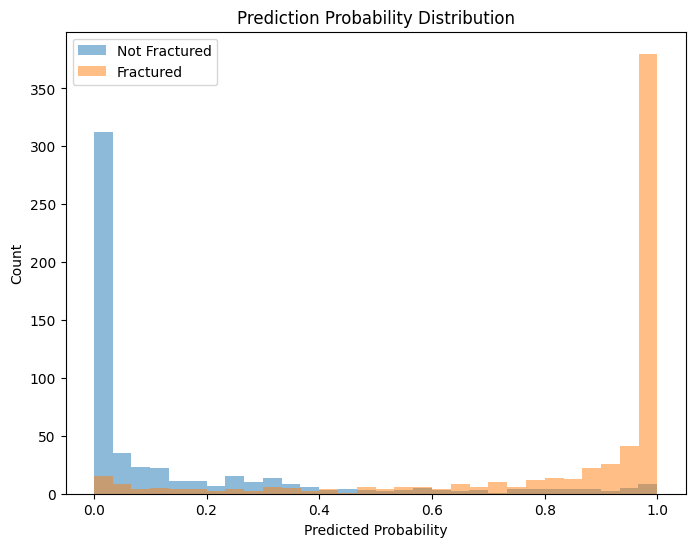

In [13]:
p_proba_dist(model, test_images, test_labels)

37/37 [==============================] - 3s 77ms/step


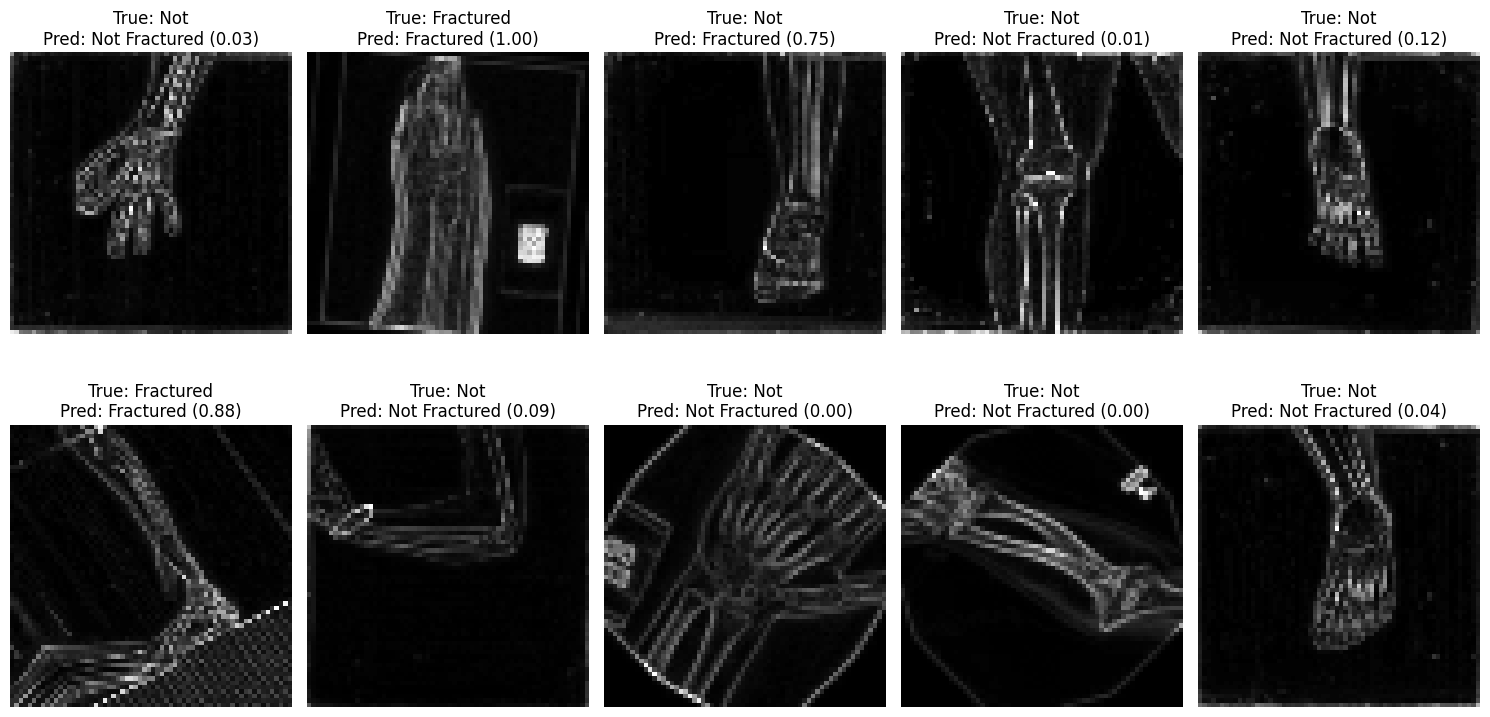

In [14]:
show_ten_samples(model, test_images, test_labels)

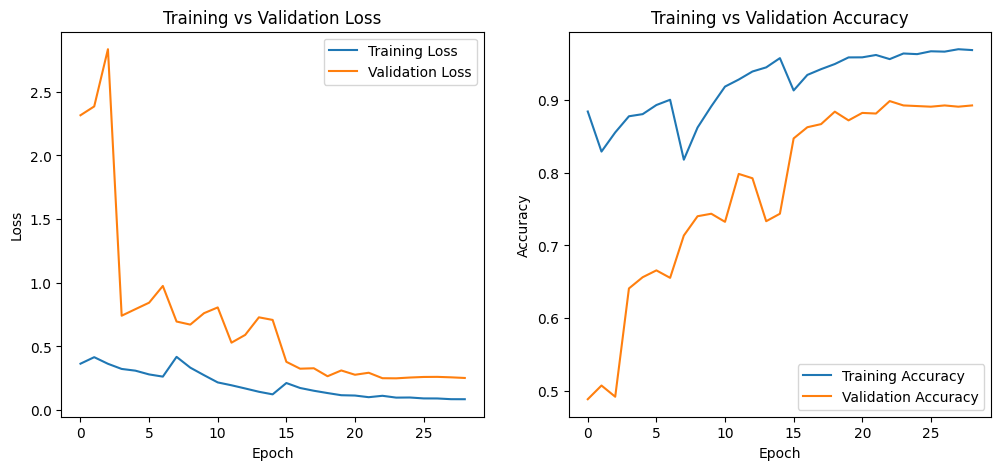

In [15]:
loss_accu_train(history)

Revisando las métricas, vamos a ajustar 8 epochs el modelo.